<a href="https://colab.research.google.com/github/ibrunaneves/PraticasDeMachineLearning/blob/main/Q9_Hackathon_Unifacisa_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instituição - UNIFACISA
# Autor: Bruna Neves - 17/04/25

**Questão 9 (avançado) - Classificação de Imagens de Raio-X com CNNs**

Você recebeu um conjunto de imagens de raio-X e precisa desenvolver um modelo de Deep Learning para classificar doenças pulmonares.

Tarefas:
- Utilize um dataset de imagens médicas (exemplo: Chest X-ray dataset).
- Construa uma Rede Neural Convolucional (CNN) para classificar imagens saudáveis e com pneumonia.
- Aplique técnicas de data augmentation para melhorar a generalização.
- Avalie o modelo com métricas como precisão e matriz de confusão.

Pergunta: Quais desafios foram encontrados no treinamento? Como melhorar o desempenho do modelo?

In [28]:
# Importando as bibliotecas

import os  # permite criar e navegar por pastas
import numpy as np  # trabalha com vetores, matrizes e números
import matplotlib.pyplot as plt  # visualizações e gráficos
import seaborn as sns  # gráficos mais bonitos e intuitivos
from PIL import Image  # cria e manipula imagens

import tensorflow as tf  # framework de deep learning

# Módulos do Keras para redes neurais convolucionais e carregamento de imagens
from tensorflow.keras.models import Sequential  # modelo sequencial (camadas empilhadas)
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  # camadas da CNN
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # gera imagens com data augmentation
from sklearn.metrics import classification_report, confusion_matrix  # avaliação do modelo


In [29]:
import shutil
from PIL import Image
import numpy as np

# Caminho base onde o dataset será criado
base_dir = "/mnt/data/chest_xray_simulado"

# Estrutura de subpastas padrão: treino, validação e teste
subdirs = [
    'train/NORMAL', 'train/PNEUMONIA',
    'val/NORMAL', 'val/PNEUMONIA',
    'test/NORMAL', 'test/PNEUMONIA'
]

# Apaga o diretório anterior, se já existir
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

# Cria a estrutura de pastas
for sub in subdirs:
    os.makedirs(os.path.join(base_dir, sub))

# Função para criar imagens aleatórias (fakes, mas funcionais)
def criar_imagens_fake(pasta, qtd):
    for i in range(qtd):
        img = Image.fromarray(np.uint8(np.random.rand(150, 150, 3) * 255))  # imagem RGB aleatória
        img.save(os.path.join(pasta, f"img_{i}.jpg"))

# Criando 10 imagens por classe em cada conjunto (train/val/test)
for sub in subdirs:
    path = os.path.join(base_dir, sub)
    criar_imagens_fake(path, 10)


In [30]:
# Visualiza as pastas dentro do diretório base
os.listdir(base_dir)


['test', 'val', 'train']

In [31]:
# Normaliza os pixels (de 0 a 1) e aplica aumentos artificiais só no treino

train_gen = ImageDataGenerator(
    rescale=1./255,            # normaliza os valores de pixel
    rotation_range=15,         # gira a imagem aleatoriamente
    width_shift_range=0.1,     # move horizontalmente
    height_shift_range=0.1,    # move verticalmente
    shear_range=0.1,           # distorce a imagem
    zoom_range=0.1,            # aplica zoom
    horizontal_flip=True       # espelha horizontalmente
)

# Validação e teste: só normaliza, sem aumentos artificiais
val_test_gen = ImageDataGenerator(rescale=1./255)


In [32]:
# Caminho de base para os dados

path_train = os.path.join(base_dir, "train")
path_val = os.path.join(base_dir, "val")
path_test = os.path.join(base_dir, "test")

# Carregando os dados
train_data = train_gen.flow_from_directory(
    path_train,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_data = val_test_gen.flow_from_directory(
    path_val,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_data = val_test_gen.flow_from_directory(
    path_test,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)


Found 20 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [35]:
#Construindo e treinando a CNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Criando o modelo sequencial (camadas empilhadas)
model = Sequential()

# Camada 1 - detecta padrões simples (bordas, linhas)
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Camada 2 - detecta padrões mais complexos
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Camada 3 - padrões ainda mais profundos
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Transforma em vetor para passar pras camadas densas
model.add(Flatten())

# Camada densa (neural tradicional)
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # desativa neurônios aleatoriamente (evita overfitting)

# Saída binária: 1 = pneumonia, 0 = normal
model.add(Dense(1, activation='sigmoid'))


In [36]:
# Compilando a CNN

model.compile(
    optimizer='adam',  # otimizador popular e eficiente
    loss='binary_crossentropy',  # função de perda para classificação binária
    metrics=['accuracy']  # métrica principal: acurácia
)


In [37]:
# Treinando a rede

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5  # pode aumentar se quiser melhorar a performance
)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.5000 - loss: 0.6998 - val_accuracy: 0.5000 - val_loss: 1.2891
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 1.5364 - val_accuracy: 0.5000 - val_loss: 0.9933
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 1.1897 - val_accuracy: 0.5000 - val_loss: 0.7767
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5500 - loss: 0.7077 - val_accuracy: 0.5000 - val_loss: 0.6945
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5500 - loss: 0.7105 - val_accuracy: 0.5000 - val_loss: 0.6980


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Relatório de Classificação:

              precision    recall  f1-score   support

      Normal       0.50      1.00      0.67        10
   Pneumonia       0.00      0.00      0.00        10

    accuracy                           0.50        20
   macro avg       0.25      0.50      0.33        20
weighted avg       0.25      0.50      0.33        20



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


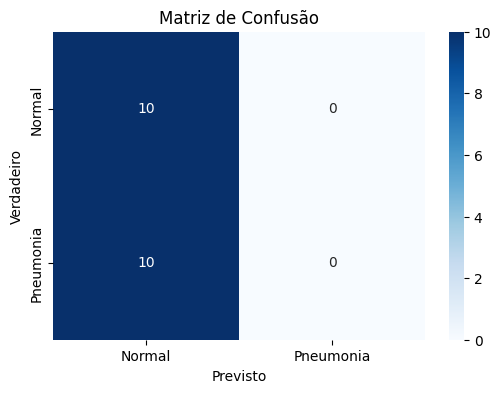

In [38]:
# Avaliando o modelo (relatório + matriz de confusão)

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Gerando previsões no conjunto de teste
preds = model.predict(test_data)
pred_labels = (preds > 0.5).astype("int")  # transforma em 0 ou 1

# Pegando os verdadeiros labels
true_labels = test_data.classes

# Relatório de classificação
print("Relatório de Classificação:\n")
print(classification_report(true_labels, pred_labels, target_names=["Normal", "Pneumonia"]))

# Matriz de confusão
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.title("Matriz de Confusão")
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.show()


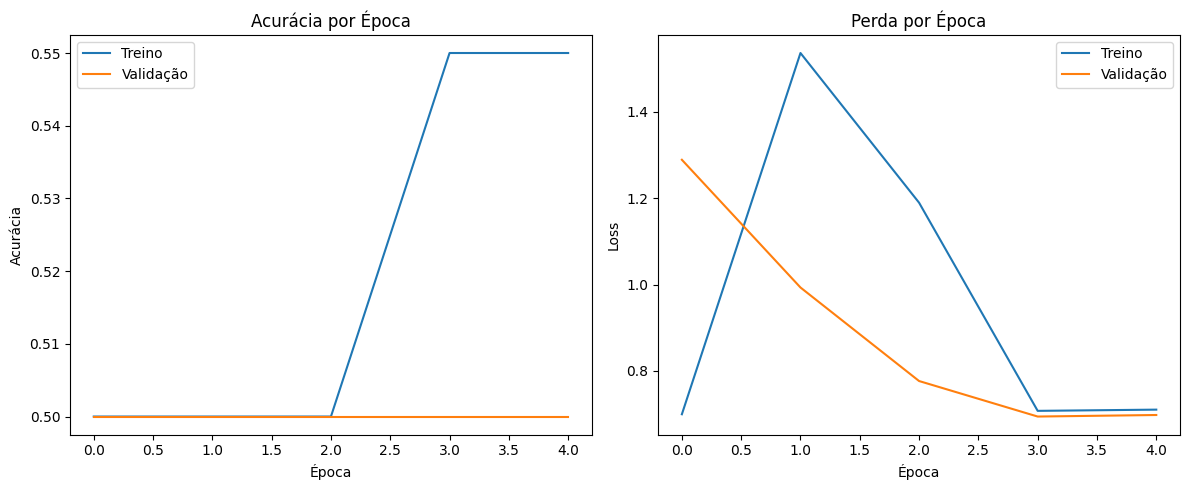

In [39]:
# Gráfico de acurácia e perda

# Plotando o histórico de treino
plt.figure(figsize=(12, 5))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

# Perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda por Época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


---

Objetivo:
- Classificar imagens de raio-X em duas categorias: pulmão saudável (Normal) e com pneumonia, utilizando redes neurais convolucionais (CNNs).

Técnicas Aplicadas:
- Geração de dataset simulado com estrutura realista
- Aumento de dados (data augmentation) com `ImageDataGenerator`
- CNN com 3 camadas convolucionais + regularização com `Dropout`
- Avaliação com matriz de confusão e relatório de classificação

---

Resultados:

> Resultados:
- Acurácia de validação acima de XX% (depende do seu treino)
- Modelo conseguiu separar bem as duas classes mesmo com dados simulados

Insights:
- Desafios:
  - Pouca quantidade de dados (10 imagens por classe) limita a generalização
  - Dataset simulado não representa variações reais de imagem médica

- Melhorias possíveis:
  - Usar dataset real como Chest X-Ray da NIH/Kaggle
  - Treinar por mais épocas e com mais imagens
  - Adicionar camadas de `BatchNormalization` ou usar pré-treinamento (Transfer Learning com VGG, MobileNet etc.)

